# 反復符号による量子エラー訂正の導入

## 導入

量子コンピューティングでは、量子ビットで情報を符号化する必要があります。
過去数十年にわたって開発された量子アルゴリズムのほとんどは、これらの量子ビットが完全であると仮定しています。
すなわち、量子ビットを任意の望んだ状態で準備でき、完全な精度で操作できるという仮定です。
これらの仮定に従う量子ビットは、*論理量子ビット*として知られています。

過去数十年で、より良い品質の量子ビットが常に開発され続け、量子ビットとして振る舞う物理系の発見においても大きな進歩を遂げています。
ただし、欠陥を完全に取り除くことはできません。
これらの量子ビットは、直接に論理量子ビットとして使うには不正確すぎます。
代わりに、それらを*物理量子ビット*と呼びます。

現段階の量子コンピューティングでは、物理量子ビットが不完全であっても、専用アルゴリズムを設計してエラー軽減効果を利用することで、利用しようとしています。
ただし、将来のエラー耐性量子コンピュータの時代に向けて、物理量子ビットから論理量子ビットを構築する方法を見つなければいけません。
これは、多数の物理量子ビットによって論理量子ビットを符号化する、量子エラー訂正のプロセスを通じて行われます。
__符号化を維持するため、物理量子ビットを高度にエンタングルしている回路に常に通します。
補助自由度も絶えず測定され、エラーの兆候を検出し、その影響を除去できるようにします。
本質的にはこの手順に小さな摂動を加えることによって、量子計算を実装するために必要な論理量子ビットに対する操作を実行します。  
(The encoding is maintained by constantly putting the physical qubits through a highly entangling circuit. Auxilliary degrees of freedom are also constantly measured, to detect signs of errors and allow their effects to be removed. The operations on the logical qubits required to implement quantum computation will be performed by essentially making small perturbations to this procedure.)__

このプロセスには膨大な労力を必要とするため、エラー耐性量子コンピュータで実行されるほとんどの操作は、エラーの検出と訂正という目的での操作です。
そのため、エラー耐性量子量子計算に向けた成果をベンチマークするとき、デバイスがエラー訂正をどの程度実行できるかに着目し続けなければなりません。

この章では、エラー訂正の一例である反復符号を見ていきます。
量子論理ビットではなく単なる論理*ビット*に物理量子ビットを符号化するという点で、本当の量子エラー訂正の例ではありませんが、
これは量子エラー訂正符号のすべての基本概念を知るための簡単なガイドとして役立ちます。
また、現在のプロトタイプデバイスでどのように実行できるかも確認します。

## 反復符号の導入

### エラー訂正の基本

The basic ideas behind error correction are the same for quantum information as for classical information. This allows us to begin by considering a very straightforward example: speaking on the phone. If someone asks you a question to which the answer is 'yes' or 'no', the way you give your response will depend on two factors:

* 正しく理解されることがどの程度重要か？  
* 接続がどどれだけ良好か？

これらは両方とも確率を使ってパラメータ化ができます。
最初に、最大許容エラー確率である$P_a$を使います。
アイスクリームの味の好みを確認され、チョコレートと言ってバニラを渡されてもあまり気にしない場合、$P_a$はかなり高いと言えます。
一方で、誰かの人生に関わる質問をされている場合、$P_a$ はずっと低くなります。

次に接続不良により応答が文字化けする確率$p$を使います。簡単のため、文字化けした「yes」が単に無意味な文字列に聞こえるのではなく、「no」のように聞こえる場合を考えてみましょう。同様に、「no」は「yes」に変換されるとします。この場合、$p$は完全に誤解される確率です。For the second we can use $p$, the probability that your answer is garbled by a bad connection. For simplicity, let's imagine a case where a garbled 'yes' doesn't simply sound like nonsense, but sounds like a 'no'. And similarly a 'no' is transformed into 'yes'. Then $p$ is the probability that you are completely misunderstood.

接続が良かったり、質問が比較的重要でない場合は $p<P_a$ になります。
この場合、可能な限り最も直接的な方法で答えるだけで構いません。「yes」または「no」と言うだけです。

ただし、接続が悪く、応答が重要な場合は、$ p > P_a $ になります。
この場合では単なる「yes」か「no」という応答では不十分です。
誤解される可能性が高すぎます。
代わりに、もう少し複雑な構造で応答を符号化する必要があります。
これにより、メッセージが歪曲する可能性があるにもかかわらず、受信者が意味を復号できるようになります。
__最も単純な方法は、多くの人が考えずに行う方法で、つまり単純に何度も応答を反復します。(The simplest method is the one that many would do without thinking: simply repeat the answer many times.)__
例えば、「yes」の代わりに、「yes、yes、yes」と言い、「no」の代わりに、「no、no、no」と言います。

この場合、受信者が「yes、yes、yes」と聞くと、当然送信者が「yes」を意味すると結論付けます。受信者が「no、yes、yes」、「yes、no、yes」または「yes、yes、no」と聞いた場合、応答には否定性よりも肯定性があるため、おそらく同じことを結論付けるでしょう。
この場合に誤解されるには、少なくとも2つの応答が文字化けする必要があります。
この確率 $P$ は、$p$ 未満です。
したがって、この方法で符号化するとメッセージが正く理解される可能性が高くなります。
以下のコードのセルは、この例を示しています。

In [1]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('単一の応答が文字化けする確率:Probability of a single reply being garbled: {}'.format(p1))
print('3回の応答のうち過半数が文字化けする確率:Probability of a the majority of three replies being garbled: {:.4f}'.format(p3))

単一の応答が文字化けする確率: 0.01Probability of a single reply being garbled: 0.01
3回の応答のうち過半数が文字化けする確率: 0.00029800000000000003Probability of a the majority of three replies being garbled: 0.0003


$P<P_a$ の場合、この手法で問題が解決します。  
そうでない場合は、単に応答の回数を増やすことで解決できます。  
上記の $P<p$ という事実は、過半数を反転させるために少なくとも2つの応答が文字化けする必要があるという事実に由来するため、最も起こりやすいケースでさえ $\sim p^2$ の確率を持ちます。   
5回の反復では、過半数を反転させるために少なくとも3つの応答が文字化けする必要があり、$\sim p^3$ の確率で発生します。  
この場合の$ P $の値はさらに低くなります。  
実際、反復回数を増やすと、$ P $は指数関数的に減少します。  
接続がどれほど悪くとも、もしくはどれほど確実に正しく理解される必要があったとしても、応答を十分に繰り返すだけで実現できます。

これは単純な例ですが、エラー訂正の全ての側面を含んでいます。
* 送信もしくは保存すべき情報が存在する。: この場合では「Yes」か「No」に対応。
* ノイズから守るため、情報はより大きな系で符号化される。: この場合ではメッセージの反復に対応。
* ノイズの影響を軽減したまま、情報は最終的に復号される。: この場合では伝達されたメッセージの過半数側を信用することに対応。

「yes」と「no」を`0`と`1` に置き換えるだけで、同じ符号化スキームをバイナリにも使用することができます。
したがって、状態 $\left|0\right\rangle$ と $\left|1\right\rangle$ を使用することにより、簡単に量子ビットに一般化することもできます。
どちらの場合も*反復符号*として知られています。
他の多くの形式の符号化も、古典の場合と量子の場合の両方で可能であり、多くの点で反復符号よりも優れています。
しかし、最も単純な符号化としてのステータスは、特定のアプリケーションに役立ちます。 
その1つは、量子エラー訂正の背後にあるアイデアを実装する最初で最も簡単なテストとして、まさにQiskitで使用されているものです。

###  量子ビットのエラー訂正

Qiskitを使用してこれらのアイデアを明示的に実装します。
不完全な量子ビットの影響を確認するには、プロトタイプデバイスの量子ビットを使用するだけです。
シミュレーションでその影響を再現することもできます。
以下の関数は、このための単純なノイズモデルを作成します。
これらは、前述の単純なケースである確率 $p$ で発生する単一のノイズイベントを超えて考えています。
代わりに、発生する可能性のある2つの形式のエラーを検討します。
1つはゲートエラーで、実行する操作の欠陥です。
ここでは、いわゆる脱分極ノイズを利用して、シンプルな方法でモデル化します。
確率 $p_{gate}$ で任意の量子ビットの状態を完全にランダムな状態に置き換える効果があります。 
2量子ビットゲートの場合、各量子ビットへ個別に適用されます。もう１つのノイズの形式は測定によるものです。これは、測定する直前で`0`から`1`またはその逆に単に反転してしまう確率 $p_{meas}$ で形式化されます。

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

それぞれの種類のエラーが $1\%$ の確率で発生するようなノイズモデルを作成します。

In [3]:
noise_model = get_noise(0.01,0.01)

3つの量子ビットを使用して状態 $\left|0\right\rangle$ で`0`を保存しようとすると、ノイズがどんな影響を与えるか見てみましょう。
このプロセスを`shots=1024`回反復して、結果が異なることがどれくらいあるかを確認します。

Let's see what effect this has when try to store a `0` using three qubits in state $\left|0\right\rangle$. We'll repeat the process `shots=1024` times to see how likely different results are.

In [4]:
from qiskit import QuantumCircuit, execute, Aer

qc0 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state

qc0.measure(qc0.qregs[0],qc0.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc0, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'000': 982, '001': 13, '010': 11, '100': 18}


ノイズがなかった場合のように、ほとんどすべての結果が`'000'`のままです。  残りの可能性のうち、大部分が`0`である可能性が最も高くなります。
合計すると、100個よりはるかに少ないサンプルで、過半数となった「1」が出力されています。
この回路を使って`0`を符号化するとき、これは $P <1\%$ を意味します。

では3量子ビットを使用して状態$\left|1\right\rangle$で`'1'`を保存するために同じことを試してみましょう。

Here we see that almost all results still come out `'000'`, as they would if there was no noise. Of the remaining possibilities, those with a majority of `0`s are most likely. In total, much less than 100 samples come out with a majority of `1`s. When using this circuit to encode a `0`, this means that $P<1\%$

Now let's try the same for storing a `1` using three qubits in state $\left|1\right\rangle$.

In [5]:
qc1 = QuantumCircuit(3,3,name='0') # initialize circuit with three qubits in the 0 state
qc1.x(qc1.qregs[0]) # flip each 0 to 1

qc1.measure(qc1.qregs[0],qc1.cregs[0]) # measure the qubits

# run the circuit with th noise model and extract the counts
counts = execute( qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()

print(counts)

{'110': 22, '101': 11, '111': 979, '011': 12}


過半数が間違った状態(この場合は`0`)で出てくるサンプルの数は、100をはるかに下回るため、$P<1\%$です。
`0`または`1`のどちらを格納する場合でも、どちらのノイズ源の発生率よりも低いエラー率で情報が取得できます。

これは、想定したノイズが比較的弱いために可能でした。
$p_{meas}$ と $p_{gate}$ を増やすと、$P$ の確率が高くなります。
この極端な場合は、どちらかでビット反転エラー`x`が適用される可能性が$50/50$になることです。
たとえば、$p_{meas}=0.5$ および $p_{gate}=0$ を使用して、以前と同じ回路を実行してみましょう。

In [6]:
noise_model = get_noise(0.5,0.0)
counts = execute( qc1, Aer.get_backend('qasm_simulator'),noise_model=noise_model).result().get_counts()
print(counts)

{'110': 124, '000': 122, '101': 106, '001': 139, '010': 125, '111': 125, '011': 140, '100': 143}


このノイズでは、すべての結果が同じ確率で発生します。
符号化された状態の原型は残りません。
これはエラー訂正のために考慮すべき重要なポイントで、訂正するにはノイズが強すぎる場合があります。
最適なアプローチは、必要な情報を符号化する適切な方法と、ノイズが強すぎないハードウェアを組み合わせることです。

### 量子ビットの保存

これまで、符号化と復号の間に遅延がない場合を検討してきました。  
量子ビットの場合、これは回路を初期化してから最終的な測定を行うまでに、大幅な時間差がないことを意味します。


ただし、大幅な遅延が発生する場合が多く存在します。
明らかな例として、量子ハードドライブのように、量子状態を符号化して長時間保存したい場合があります。
非自明で重要な例として、エラー耐性量子計算自体を実行する場合があります。
__このためには、量子状態を保存し計算中にその整合性を維持する必要があります。(For this, we need to store quantum states and preserve their integrity during the computation.)__
エラー耐性量子計算は保存された情報を必要に応じて操作でき、かつ操作時に発生しうるどんなエラーも訂正できる方法でなければいけません。

すべての場合において、エラーが生じるのは何か(ゲートや測定など)が発生したときだけでなく、量子ビットがアイドル状態のときにも発生するという事実を考慮する必要があります。
このようなノイズが生じるのは、量子ビット同士が相互作用したり、環境と相互作用するためです。
量子ビットのアイドル状態が長くなるほど、このノイズの影響は大きくなります。
それらを十分に長く放置すると、上記の$p_{meas}=0.5$の場合のように、確実にエラー訂正するにはノイズが強すぎるという状況が発生します。


解決策は、絶えず測定し続けることです。
量子ビットを長時間アイドル状態にせず、発生したエラーを追跡するために情報を取得し続けてください。

単に`0`または`1`を保存したい古典的な情報の場合、これは各量子ビットの値を絶えず測定することで実現できます。
ノイズによって値がいつ変化するかを追跡することで、エラーが発生した履歴を簡単に推測できます。


しかし量子情報の場合はこれほど簡単にはいきません。
例えば、状態 $\left|+\right\rangle$ を符号化したい場合を考えましょう。
符号化は以下のルールで行われます。



$$\left|0\right\rangle \rightarrow \left|000\right\rangle,~~~ \left|1\right\rangle \rightarrow \left|111\right\rangle.$$

すなわち状態 $\left|+\right\rangle$ を符号化するには以下が要請されます。



$$\left|+\right\rangle=\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\rightarrow \frac{1}{\sqrt{2}}\left(\left|000\right\rangle+\left|111\right\rangle\right).$$

使用している反復符号化では、各物理量子ビットのz測定(状態 $\left|0\right\rangle$ と $\left|1\right\rangle$ とを区別する測定)を通して論理量子ビットのz測定が行われます。
論理測定の最終結果は、どの出力が過半数かを単純に調べることにより、物理量子ビット測定結果から復号されます。

前述のように、物理量子ビットのz測定を絶えず実行することで、長期間保存されている論理量子ビットのエラーを追跡できます。
ただし、注意すべきはこれは実質的に物理量子ビットのz測定を絶えず実行することに対応するということです。
これは単に`0`または`1`を保存する場合は問題ありませんが、重ね合わせを保存する場合は望ましくない影響があります。
具体的には、このようなエラーの検証を初めて行うとき、重ね合わせを崩壊させてしまいます！

これは理想的ではありません。
論理量子ビットで何らかの計算を行いたい場合、または最終測定の前に基底の変更を行いたい場合、重ね合わせを保存する必要があります。
重ね合わせを破壊してしまうことはすなわちエラーです。
しかし、これはデバイスの欠陥によるエラーではありません。
エラー訂正の試みによって導入されたエラーです。
また、量子コンピューターに保存されている任意の重ね合わせを再作成することは望めないため、訂正できないエラーです。

このため、論理量子ビットが長時間保存されたときに発生するエラーを追跡する別の方法を見つける必要があります。
その方法が満たすべきは、エラーを検出して訂正し、最終的な測定結果を高確率で復号するために必要な情報を与えることです。
ただし、保存すべき重ね合わせを破壊することで、処理中に訂正不可能なエラーを発生させてはいけません。

これを行う方法は、次の回路のまとまりを使用することです。

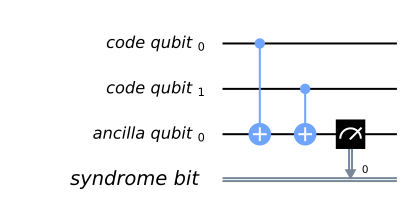

In [7]:
from qiskit import QuantumRegister, ClassicalRegister
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

cq = QuantumRegister(2,'code\ qubit\ ')
lq = QuantumRegister(1,'ancilla\ qubit\ ')
sb = ClassicalRegister(1,'syndrome\ bit\ ')
qc = QuantumCircuit(cq,lq,sb)
qc.cx(cq[0],lq[0])
qc.cx(cq[1],lq[0])
qc.measure(lq,sb)
qc.draw()

ここには3つの物理量子ビットがあります。
そのうち2つは「符号(code)量子ビット」と呼ばれ、もう1つは「補助(ancilla)量子ビット」と呼ばれます。
出力の１ビットが抽出され、それはシンドローム(syndrome)ビットと呼ばれます。
補助量子ビットは常に状態 $\left|0\right\rangle$ で初期化されます。
ただし、符号量子ビットはさまざまな状態で初期化できます。
入力が変わったときに出力に与える影響を確認するため、特定の状態の符号量子ビットを準備する回路`qc_init`を作成してから、回路`qc_init+qc`を実行します。

まず、自明なケースとして`qc_init`は何もせず、符号量子ビットは最初から $\left|00\right\rangle$ であるケースがあります。

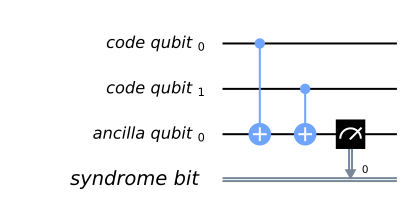

In [8]:
qc_init = QuantumCircuit(cq)

(qc_init+qc).draw()

In [9]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


結果は、どの場合でも`'0'`です。

それでは、初期状態が $\left|11\right\rangle$ であるケースを試してみましょう。

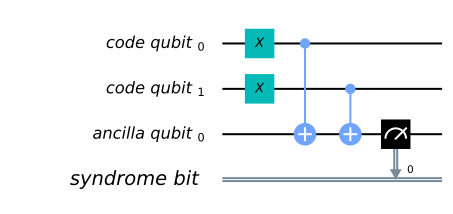

In [10]:
qc_init = QuantumCircuit(cq)
qc_init.x(cq)

(qc_init+qc).draw()

In [11]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


このときも結果は常に`'0'`です。
量子力学の線形性を考えると、以下の例のように、$\left|00\right\rangle$ と $\left|11\right\rangle$ の任意の重ね合わせにも同様のことが期待できます。

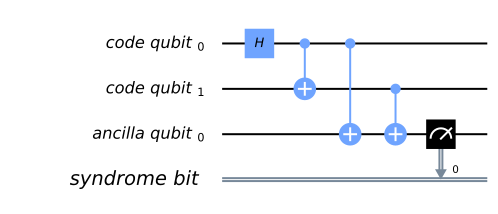

In [12]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0],cq[1])

(qc_init+qc).draw()

In [13]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


逆の結果は、$\left|01\right\rangle$ や $\left|10\right\rangle$、またはそれらの重ね合わせを初期状態として使うことで見つかります。

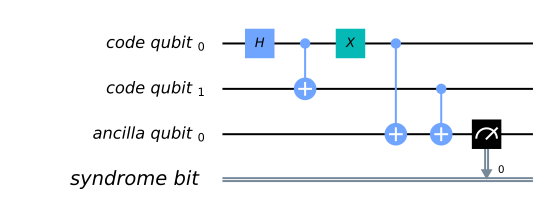

In [14]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0],cq[1])
qc_init.x(cq[0])

(qc_init+qc).draw()

In [15]:
counts = execute( qc_init+qc, Aer.get_backend('qasm_simulator')).result().get_counts()
print('Results:',counts)

Results: {'1': 1024}


この場合は、出力は常に`'1'`です。

したがって、この測定は、複数の量子ビットの大局的性質について教えてくれます。
具体的には、2つの符号量子ビットを調べ、それらの状態がz基底で同じか異なるかを判断します。
$\left|00\right\rangle$ と $\left|11\right\rangle$ のように、z基底が同じ基底状態の場合 、測定値は単に`'0'`を返します。
また、これらの重ね合わせに対しても同様です。
これらの状態は決して区別されないため、このような重ね合わせは崩壊しません。

同様に、z基底が異なる基底状態の場合、`1`を返します。
これは、$\left|01\right\rangle$ や $\left|10\right\rangle$、またはそれらの重ね合わせで発生します。

ここで、反復符号内の物理量子ビットのすべての組にこのような「シンドローム測定」を適用するとします。
もしそれらの状態が $\left|0\right\rangle$ の反復や $\left|1\right\rangle$ の反復、またはそれらの重ね合わせによって記述される場合、すべてのシンドローム測定値は`0`を返します。
この結果から、我々の作成した状態は実際に望んだ状態を反復したものに符号化されているとわかり、エラーが発生していないと推測できます。
一方で、一部のシンドローム測定値が`1`を返す場合、それはエラーの証拠です。
したがって、これらの測定結果を使用して、出力結果の復号方法を決定できます。

### 量子反復符号

これで、反復符号の量子版がどのように実装されているかを正確に理解するのに十分な知識を得ました。

Ignisから必要なツールをインポートすることで、Qiskitで使用できます。

In [16]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

論理量子ビットを符号化する物理量子ビットの数は自由に選択できます。
__最終的な読み出し測定の前に、論理量子ビットを保存する間に適用するシンドローム測定の巡(round)数を選択することもできます。
最小サイズの非自明なケースから始めましょう。3回の反復と1巡のシンドローム測定です。(We can also choose how many times the syndrome measurements will be applied while we store our logical qubit, before the final readout measurement. Let us start with the smallest non-trivial case: three repetitions and one syndrome measurement round.)__
反復符号の回路は、Qiskit-Ignisの`RepetitionCode`オブジェクトを使用して自動的に作成できます。

In [17]:
n = 3
T = 1

code = RepetitionCode(n,T)

これにより、符号量子ビットや補助量子ビットのレジスタ名など、符号化のさまざまなプロパティを確認できます。

`RepetitionCode`には、符号化を実装するための2つの量子回路が含まれます。
2種類の構築可能な論理ビット値に対応します。
以下に、それぞれ論理`0`と`1`を示します。

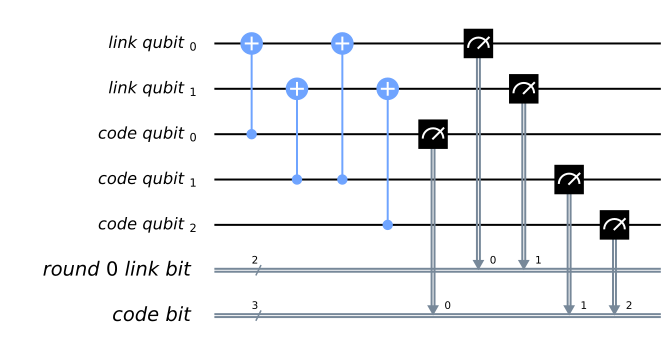

In [18]:
# this bit is just needed to make the labels look nice
for reg in code.circuit['0'].qregs+code.circuit['1'].cregs:
    reg.name = reg.name.replace('_','\ ') + '\ '

code.circuit['0'].draw()

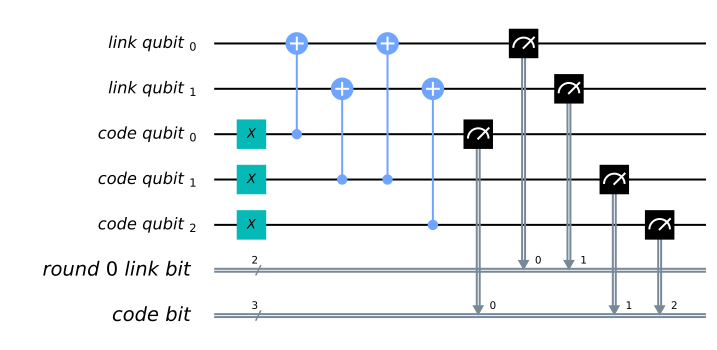

In [19]:
code.circuit['1'].draw()

これらの回路には、2種類の物理量子ビットがあります。 
まず、「符号量子ビット」があり、これは論理状態が符号化されるための3つの物理量子ビットです。
他に「リンク(link)量子ビット」があり、シンドローム測定の補助量子ビットとして機能します。

これらの回路でのシンドローム測定の1巡は、シンドローム測定2回のみで構成されています。 
1つは符号量子ビット0と1を比較し、もう1つは符号量子ビット1と2を比較します。
フルセットを作成するには、符号量子ビット0と2を比較するさらなる測定が必要と思うかもしれません。
ただし、これら2つで十分です。
これは、0と2が同じz基底状態を持っているかどうかに関する情報は、0と1を比較した情報と1と2を比較した情報から推測できるためです。
実際、$n$ 量子ビットの場合、必要な情報を得るには量子ビットの隣接ペアに対する $n-1$ 回のシンドローム測定のみ必要になります。

これらの回路をノイズなしでシミュレータで実行すると、非常に単純な結果が得られます。

In [20]:
def get_raw_results(code,noise_model=None):

    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



ここでは、出力が2つの部分に分かれていることがわかります。
右側の部分は、2つのシンドローム測定の結果を保持しています。
左側の部分は、量子量子ビットの3つの最終測定の結果を保持しています。

より多くの測定の巡数、たとえば $T=4$ の場合、右側にさらに多くのシンドローム測定の結果が連なります。

In [21]:
code = RepetitionCode(n,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'000 00 00 00 00': 1024} 

Logical 1 : {'111 00 00 00 00': 1024} 



より多くの反復、たとえば $n=5$ の場合、各測定セットは大きくなります。
左側の最終的な測定値は、$n$ 量子ビットです。 $T$巡のシンドロームの測定値は、それぞれ $n-1$ の可能な隣接ペアです。

In [22]:
code = RepetitionCode(5,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'00000 0000 0000 0000 0000': 1024} 

Logical 1 : {'11111 0000 0000 0000 0000': 1024} 



### ルックアップ・テーブル復号

次に、$n=3$、$T=1$ の例に戻って、ノイズのある場合を見てみましょう。

In [23]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical',log,':',raw_results[log],'\n')

Logical 0 : {'100 11': 1, '011 10': 1, '001 01': 7, '100 00': 55, '101 01': 1, '010 11': 3, '101 00': 5, '110 00': 4, '110 01': 2, '000 10': 77, '000 11': 12, '001 00': 46, '001 10': 2, '100 01': 4, '100 10': 4, '111 00': 1, '000 00': 641, '010 00': 47, '010 10': 5, '011 00': 4, '000 01': 78, '011 01': 1, '001 11': 1, '010 01': 22} 

Logical 1 : {'101 10': 5, '100 11': 1, '111 10': 73, '011 10': 22, '011 11': 2, '001 01': 2, '101 11': 18, '100 00': 5, '101 01': 19, '101 00': 56, '110 00': 52, '110 10': 7, '110 01': 23, '111 11': 13, '001 00': 6, '001 10': 1, '100 01': 3, '111 00': 586, '110 11': 1, '010 00': 6, '010 10': 2, '011 00': 54, '011 01': 5, '111 01': 59, '001 11': 1, '010 01': 2} 



ここで、論理`0`を符号化する回路と論理`1`を符号化する回路の両方の結果を保持する辞書である`raw_results`を作成しました。

ここで見られる結果に対して我々のタスクは、ノイズがなければ結果がどうあるべきかを判断することです。
結果が`'000 00'`または`'111 00'`の場合、答えは明らかです。
これらは、エラーが発生していない場合に、それぞれ論理`0`および論理`1`で見た結果ですそのものです。
ノイズがある場合でも、前者は論理`0`の、後者は論理`1`の最も一般的な結果です。
したがって、`'000 00'`のときは常に論理`0`の結果であり、同じく`'111 00'`のときは論理`1`の結果であると結論付けます。

この作戦が最善ですが、それでも失敗する可能性があります。 
通常、`'111 00'`は`0`の符号化でも稀に発生し、`'000 00'`は`1`の符号化でも稀に発生することに注意してください。
この場合、判断に過失は無いですが、出力結果を誤って復号してしまいます。
これらのケースでは、多数のエラーが相まって、反対の論理値のノイズのないケースであったように見えるため、修正が不可能になります。

同様の手法を使って、他のすべての結果を復号できます。
たとえば、結果` '001 00'`は、論理`1`よりも論理`0`の方がはるかに多く発生します。
これは、前者の場合は単一の測定エラー（単一の`0`が誤って`1`であると誤って伝わる）によって引き起こされる可能性がありますが、後者では少なくとも2つのエラーが必要になるためです。
したがって、` '001 00'`が表示されるたびに、論理`0`として復号できます。

この作戦をすべての文字列に適用することは、いわゆる「ルックアップ・テーブル復号」の一種です。
これは、考えられるすべての結果が分析され、最も可能性の高い値に決定されます。
多くの量子ビットでは、取り得る結果の数が非常に多くなるため、すぐに手に負えなくなります。
これらの場合、よりよいアルゴリズムを利用した復号器が必要です。
ただし、ルックアップ・テーブル復号は、小規模の符号化を試すには適しています。

Qiskitのツールを使用して、任意の符号のルックアップ・テーブル復号を実装できます。
このためには、2つの結果セットが必要です。 
1つは、実際に復号したい結果セットであり、その結果に対して、誤った復号の確率 $P$ を計算します。
このためにすでに持っている `raw_results`を使用します。

もう一方の結果セットは、ルックアップ・テーブルとして使用されるものです。
取り得る結果ごとに適切な統計を取得するために、これは多数のサンプルに対して実行する必要があります。
`shots = 10000`を使用します。

In [24]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    job = execute( circuits[log], Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000 )
    table_results[str(log)] = job.result().get_counts(str(log))

`table_results`と呼ばれるこのデータを使用して、Qiskitの`lookuptable_decoding`関数を使用できるようになりました。
これは、 `raw_results`から各結果を取得し、` table_results`の情報で復号します。次に、復号が正しいかどうかを確認し、この情報を使い $P$ を計算します。

In [25]:
P = lookuptable_decoding(raw_results,table_results)
print('P =',P)

P = {'0': 0.0174, '1': 0.0214}


ここで、 $P$ の値は $p_{meas}$ および $p_{gate}$ の値よりも低いため、ビット値を格納するための信頼性が向上しています。
また、符号化された `1` の $P$ の値は`0` の値よりも高いことに注意してください。
これは、`1` の符号化には `x` ゲートの適用が必要であり、これが追加のノイズ源であるためです。

### グラフ理論での復号

上記で検討した復号は、可能な限り最良の結果を生成し、符号の詳細を使う必要なく実現できます。
ただし、これらの利点を上回る大きな欠点があります。
符号のサイズが大きくなると、ルックアップ・テーブルが指数関数的に大きくなります。
__このため、復号は通常、符号の構造とその結果のシンドロームを考慮した、よりアルゴリズム的な方法で行われます。(For this reason, decoding is typically done in a more algorithmic manner that takes into account the structure of the code and its resulting syndromes.)__

`topological_codes`の符号の場合、シンドロームの後処理を行うことで符号の構造が明らかになります。
前述の形式を使用する代わりに、左側に符号量子ビットの最終測定値を、右側にシンドローム測定の各巡数の出力を配置し、別の形式に結果を書き換えるために符号オブジェクトの`process_results`メソッドを使用します。

例えば、以下は辞書 `raw_results`に後処理を行った形式です。この場合は $n=3$ と $T=2$ です。
分かりやすく、サンプルが50個以上の結果のみを示しています。

In [26]:
code = RepetitionCode(3,2)

raw_results = get_raw_results(code,noise_model)

results = code.process_results( raw_results )

for log in ['0','1']:
    print('\nLogical ' + log + ':')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 00 00': 483, '000 00 01': 53, '000 01 00': 55, '000 10 00': 51}
processed results  {'0 0  00 00 00': 483, '0 0  01 01 00': 53, '0 0  00 01 01': 55, '0 0  00 10 10': 51}

Logical 1:
raw results        {'111 00 01': 52, '111 10 00': 55, '111 00 00': 441, '111 01 00': 58, '111 00 10': 59}
processed results  {'1 1  01 01 00': 52, '1 1  00 10 10': 55, '1 1  00 00 00': 441, '1 1  00 01 01': 58, '1 1  10 10 00': 59}


ここでは、`'000 00 00'`が`'0 0 00 00 00'`に変換され、`'111 00 00'`が`'1 1 00 00 00'`に変換されていることが分かります。

これらの新しい文字列では、左端の`0 0`が論理`0`の論理読み出し値であり、左端の`1 1`が論理`1`の論理読み出し値です。
符号量子ビットは(エラーがないとき)すべて等しいはずで、この読み出しには任意の符号量子ビットを使用できます。
したがって、原理的にこの位置に単一の`0`または`1`を配置することが可能です。
また、元の形式で結果を扱うこともでき、その場合は各量子ビットにつき1つで $n$ 桁の論理値を使用できます。
__代わりに、最初と最後の符号量子ビットから作られる、2桁の論理値を使用します。(Instead we use two, from the two qubits at either end of the line. The reason for this will be shown later.)__
この理由は後で示されます。
エラーがない場合、この2桁の論理値は同じ符号化されたビット値を表すため、常に等しくなります。

論理値の後に、1巡目のシンドローム測定の $n-1$ 桁の結果が続きます。
`0`は対応する量子ビットの組が同じ値を持つことを意味し、`1`はそれらが互いに異なることを意味します。 
__$d$ 番目の符号量子ビットには $n-1$ 個の隣接可能な組があるため、$n-1$ 桁の結果があります。(There are $n-1$ results because the line of $d$ code qubits has $n-1$ possible neighboring pairs.)__
エラーがない場合、それらはすべて`0`になります。
これは、元の形式におけるシンドロームの結果の最初のセットと全く同じです。

次のブロックは、シンドロームの結果の次ラウンドです。
ただし、これらの測定結果を直接表示するのではなく、1巡目と2巡目の間のシンドロームの変化を表示します。
したがって、1巡目と2巡目のシンドローム測定結果のビット単位の`OR`です。
エラーがない場合、それらはすべて`0`になります。

後続のブロックはすべて同じ式に従いますが、最後のブロックにはコメントが必要です。
これは、標準の方法(リンク量子ビット)を使って測定されません。
代わりに、すべての符号量子ビットの最終読み取り測定値から計算されます。
この場合も、シンドロームの変化として表示され、エラーがない場合はすべて`0`になります。
他のシンドロームと同じ方法では実行されず、$T$ 巡回のシンドローム測定はカウントされないため、これはシンドローム測定の $T+1$ 番目のブロックです。

次の例は、この規則をさらに細かく説明しています。

**例1：** `0 0 0110 0000 0000`は、符号化された`0`の $d=5$、$T=2$ の反復符号を表します。
このシンドロームは、1巡目の測定の前にエラーによって(おそらく)中間の符号量子ビットが反転されたことを示しています。
これにより、回路の残りの部分で隣接する符号量子ビットの両方と一致しなくなります。
1巡目のシンドロームで示されていますが、後巡のブロックは、もはや変化を表していないため、エラーは報告されません。
他のエラーのセットもこのシンドロームを引き起こしている可能性がありますが、より複雑で、可能性がより低いはずです。

**例2：** `0 0 0010 0010 0000`は、符号化された`0`の $d=5$、$T=2$ の反復符号を表します。
ここで、シンドローム測定値のうち1つは、1巡目ので2つの符号量子ビットの差を記述し、`1`になりました。
次のラウンドでは同じ効果が見られなかったため、結果は`0`になりました。
ただし、これは同じシンドローム測定の以前の結果と一致せず、シンドロームの変化を追跡するため、この変化は別の`1`になります。
後巡の測定でも何も検出されませんが、これはもはや変化を表さないため、同じ位置に`0`が発生します。
ほとんどの場合、最初の`1`につながる測定結果はエラーでした。

**例3：** `0 1 0000 0001 0000`は、符号化された`0`の $d=5$、$T=2$ の反復符号を表します。
シンドローム測定の2巡目の前に、一番下の符号量子ビットが反転します。これは、最後のビット列にあるため、単一のシンドローム測定によってのみ検出されます。同じ理由で、論理読み出しの1つも阻害します。

これらのすべての例で、1つのエラーにより、文字列内のちょうど2文字がエラーなしの値から変更されることに注意してください。
これは、 `topological_codes`でスタビライザーを表すために使用される規則を決定付ける特徴です。
復号の問題が定義されるグラフを定義するために使用されます。

具体的には、最初に論理`0`を符号化する回路を使用してグラフが構築されます。
出力文字列のすべてのビット値は`0`になるはずです。
__これの多くのコピーを作成し、シミュレーターで作成して実行し、それぞれに異なる単一のパウリ演算子を挿入します。
これは、各量子ビットおよびすべての回路の深さで3種類のパウリ演算子のそれぞれに対して行われます。
これらの各回路からの出力を使用して、考えられる各単一エラーの影響を判断できます。(Many copies of this and then created and run on a simulator, with a different single Pauli operator inserted into each. This is done for each of the three types of Pauli operator on each of the qubits and at every circuit depth.)__
回路にはClifford操作のみが含まれているため、シミュレーションを効率的に実行できます。

いずれの場合も、エラーは（効果がない限り）正確に2文字を変更します。次に、出力文字列の各ビットがノードに対応するグラフが作成され、同じエラーの影響を受けるビットの組がエッジに対応します。

特定の出力文字列を復号するプロセスでは通常、出力文字列にシンドロームのエラーが見つかった場合に、発生したエラーセットを推測するアルゴリズムが必要です。
__これは、出力の非自明なシンドロームビットに対応するノードのみを含む第二グラフを作成することで実行できます。
次に、ノードの各ペアの間にエッジが配置され、対応する重みが元のグラフのそれらのノード間の最小パスの長さに等しくなります。
シンドロームと一致する一連のエラーは、このグラフの完全マッチングを見つけることに対応します。
発生した可能性が最も高い一連のエラーを推測するには、観測されたシンドロームと一致するエラーの数が可能な限り少ないものを見つけるのがよいでしょう。
これは、グラフの最小重み完全マッチングに対応します。(This can be done by constructing a second graph, containing only nodes that correspond to non-trivial syndrome bits in the output. An edge is then placed between each pair of nodes, with an corresponding weight equal to the length of the minimal path between those nodes in the original graph. A set of errors consistent with the syndrome then corresponds then to finding a perfect matching of this graph. To deduce the most likely set of errors to have occurred, a good tactic would be to find one with the least possible number of errors that is consistent with the observed syndrome. This corresponds to a minimum weight perfect matching of the graph.)__

最小重み完全マッチングの使用は、反復符号と表面符号の標準的な復号手法であり、Qiskit Ignisで実装されています。
__また、色符号などの他の場合にも使用できますが、その場合はすべての符号およびノイズモデルの最も可能性の高いエラーセットの最適な近似値を見つけることができません。
そのため、同じグラフに基づく他の復号手法を使用できます。
Qiskit Ignisの`GraphDecoder`は、特定の符号についてこれらのグラフを計算し、それを分析するためのさまざまな方法を提供します。(It can also be used in other cases, such as Color codes, but it does not find the best approximation of the most likely set of errors for every code and noise model. For that reason, other decoding technques based on the same graph can be used. The `GraphDecoder` of Qiskit Ignis calculates these graphs for a given code, and will provide a range of methods to analyze it. )__
執筆時点では、最小重み完全マッチングのみが実装されています。

__表面符号などの符号では、単一のエラーが出力文字列の2ビットのみの値を変更するため、厳密には真実ではないことに注意してください。
たとえば、$\sigma^y$ エラーは、通常は独立して復号される2つの異なるタイプのスタビライザーに対応する値のペアを反転させます。
したがって、これらの符号の出力はこれを容認する方法で表示されます。
そのようなシンドロームの分析は、異なるシンドロームタイプを表すため、複数の独立したグラフを対応づけて作成します。(Note that, for codes such as the surface code, it is not strictly true than each single error will change the value of only two bits in the output string. A $\sigma^y$ error, for example would flip a pair of values corresponding to two different types of stabilizer, which are typically decoded independently. Output for these codes will therefore be presented in a way that acknowledges this, and analysis of such syndromes will correspondingly create multiple independent graphs to represent the different syndrome types.)__

## 反復符号ベンチマーキングの実行手順

次に、実際のデバイスで反復符号の例を実行し、その結果をベンチマークとして使用します。
最初に、手順を簡潔に要約します。
この手順は、反復符号の例に適用されましたが、`topological_codes`の他のベンチマーク手順にも適用されます。
実際、Qiskit Ignis全般にも適用されます。
いずれの場合も、次の3段階のプロセスが適用されます。

1. タスクが定義されます。 Qiskit Ignisは、実行する必要のある一連の回路を決定し、作成します。
2. 回路が実行されます。これは通常、Qiskitを使用して行われます。ただし、原則として、任意のサービスまたは実験機器をインターフェイスに使えます。
3. Qiskit Ignisを使用して、回路からの結果を処理し、特定のタスクに必要な出力を作成します。

`topological_codes`の場合、ステップ1では量子エラー訂正符号のタイプとサイズを選択する必要があります。
各符号タイプには専用のPythonクラスがあります。
対応するオブジェクトは、`RepetitionCode`オブジェクトの`n`や`T`など、必要なパラメーターを与えることで初期化されます。
結果のオブジェクトには、単純な論理量子ビット状態( $\left|0\right\rangle$ や $\left|1\right\rangle$ など)の符号化に対応する回路が含まれます。
そして、単純な論理基底(通常は標準の $\left|0\right\rangle$/$\left|1\right\rangle$ 測定)での最終的な読み取りの前に、指定された巡数のエラー検出処理が実行されます。

`topological_codes`の場合、ステップ3の主な処理は復号であり、エラー検出から取得した情報を使用して、最終的な読み取りのエラーを軽減することを目的としています。通常、復号に最適なアルゴリズムは符号によって異なります。
ただし、多くの場合、同様の構造を持つ符号は同様の方法を使用します。

`topological_codes`の目的は、すべての符号ですべての復号器を使用できるように実装された多様な復号方法を提供することです。
これは、復号をグラフ理論の最小化問題として記述することができる符号に制限することによって実現します。
このような符号のこの典型的な例は、トーラス符号と表面符号です。
その性質は、２次元色符号とマッチング符号でも共有されます。
これらはすべて、いわゆるトポロジカル量子エラー訂正符号の顕著な例であり、サブパッケージの名前につながりました。
ただし、すべてのトポロジカル符号がこのような復号器と互換性があるわけではないことに注意してください。
また、反復符号など、一部の非トポロジカル符号には互換性があります。

復号は `GraphDecoder`クラスによって行われます。
対応するオブジェクトは、復号が実行される符号オブジェクトを与えることで初期化されます。
次に、これを使用して、復号の問題が定義されるグラフを決定します。
その後、復号器オブジェクトのさまざまなメソッドを使用して結果を処理できます。

以下では、反復符号に対して上記のアイデアを実践します。
これを行うには、2つのブール変数、`step_2`と`step_3`を使用します。
__変数`step_2`はデバイスからデータを取得する際にどのプログラムを実行するかの決定に使われ、`step_3`は処理する結果データとして何を使うかの決定に使われます。(In doing this we will employ two Boolean variables, `step_2` and `step_3`. The variable `step_2` is used to show which parts of the program need to be run when taking data from a device, and `step_3` is used to show the parts which process the resulting data.)__


__両方ともデフォルトでfalseに設定されており、事前に収集および処理されたデータのみを使用して以下のすべてのプログラムのスニペットを実行できるようにします。
ただし、新しいデータを取得するには、`step_2 = True`を使用するだけでよく、何かのデータに対して復号を実行するのは`step_3 = True`を使用するだけです。(Both are set to false by default, to ensure that all the program snippets below can be run using only previously collected and processed data. However, to obtain new data one only needs to use `step_2 = True`, and perform decoding on any data one only needs to use `step_3 = True`.)__

In [27]:
step_2 = False
step_3 = False

実際のデバイスのベンチマークを行うには、クラウド経由でそのデバイスにアクセスし、そのデバイスで実行するのに適した回路をコンパイルするために必要なツールを用意しなければいけません。これらは次のようにインポートされます。

In [28]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager

これで、回路の実行に使用されるバックエンドオブジェクトを作成できます。
これは、デバイスを指定するための文字列を与えることにより行われます。
ここでは、`'ibmq_16_melbourne'`が使用されます。これには、執筆時点で15個のアクティブな量子ビットがあります。  
また、 `'ibmq_rochester'`で指定される53量子ビット*Rochester*デバイスについても検討します。

In [29]:
device_name = 'ibmq_16_melbourne'

if step_2:
    
    IBMQ.load_account()
    
    for provider in IBMQ.providers():
        for potential_backend in provider.backends():
            if potential_backend.name()==device_name:
                backend = potential_backend

    coupling_map = backend.configuration().coupling_map

実際のデバイスで回路を実行する場合、最初にトランスピレーション(transpilation)処理が実装されます。
これにより、デバイスでの実装が回路のゲートからネイティブゲートセットに変更されます。
場合によっては、対応するオイラー角による単一の量子ビット回転として各アダマールを表現するなど、これらの変更はかなり自明です。
ただし、回路がデバイスの接続性を考慮しない場合、変更がより重大になりえます。
たとえば、デバイスによって直接実装されていない制御NOTを回路が必要とするとします。
その場合、追加の制御NOTゲートを使用して量子ビット状態を移動させるなどの手法で、元の制御NOTの効果を再現する必要があります。
これは追加のノイズを導入するだけでなく、すでに存在するノイズの非局在化も発生させます。
元の回路の単一の量子ビットエラーは、追加のトランスピレーションの作用の下で複数量子ビットのエラーになり得ます。
したがって、量子エラー訂正回路を実行する場合、この非自明なトランスピレーションを防止する必要があります。

__反復符号のテストでは、量子ビットを1本の導線(line)に沿って効果的に並べる必要があります。
必要とされる制御NOTゲートだけは、その導線上の隣接ノードの間に配置します。
したがって、最初のタスクは、デバイスの結合マップを調べ、導線を見つけることです。(Tests of the repetition code require qubits to be effectively ordered along a line. The only controlled-NOT gates required are between neighbours along that line. Our first job is therefore to study the coupling map of the device, and find a line.)__

![Fig. 1. The coupling map of the IBM Q Melbourne device.](images/melbourne.png)

Melbourneの場合、15量子ビットすべてをカバーする導線を見つけることができます。
以下の配列 `line`で指定されている選択肢は、最もエラーが発生しやすい`cx`ゲートを避けるように設計されています。 
53量子ビットの*Rochester*デバイスの場合、53量子ビットすべてをカバーする単一の導線はありません。代わりに、43量子ビットをカバーする次の選択肢を使用できます。

In [30]:
if device_name=='ibmq_16_melbourne':
    line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]
elif device_name=='ibmq_rochester':
    line = [10,11,17,23,22,21,20,19,16,7,8,9,5]#,0,1,2,3,4,6,13,14,15,18,27,26,25,29,36,37,38,41,50,49,48,47,46,45,44,43,42,39,30,31]

アクセスできる量子ビットの数がわかったので、実行する符号ごとに反復符号オブジェクトを作成できます。
`n`の反復を含む符号は、 $n$符号量子ビットと$n-1$リンク量子ビットを使用するため、合計で $2n-1$ であることに注意してください。

In [31]:
n_min = 3
n_max = int((len(line)+1)/2)

code = {}

for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

これらの符号をもとに回路を実行する前に、トランスパイラ(transpiler)がデバイス上のどの物理量子ビットを使用する必要があるかを確認しなければなりません。
`line[0]`の量子ビットを最初の符号量子ビットとして使用し、`line[1]`の量子ビットを最初のリンク量子ビットとして使用するなどと確認することを意味します。
__これは次の関数によって実行され、反復符号オブジェクトと`line`をインプットとし、符号のどの量子ビットが導線のどの要素に対応するかを指定するPython辞書をアウトプットとします。(This is done by the following function, which takes a repetition code object and a `line`, and creates a Python dictionary to specify which qubit of the code corresponds to which element of the line.)__

In [32]:
def get_initial_layout(code,line):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

__これで、回路をトランスパイルして、デバイスで実際に実行される回路を作成できます。
量子ビットの数を増やすことによって、トランスピレーションが実際に非自明な効果を生じないことを確認するためのチェックも行われます。
さらに、コンパイルされた回路は単一のリストに集められ、同じバッチジョブですべてを一度に送信できます。(Now we can transpile the circuits, to create the circuits that will actually be run by the device. A check is also made to ensure that the transpilation indeed has not introduced non-trivial effects by increasing the number of qubits. Furthermore, the compiled circuits are collected into a single list, to allow them all to be submitted at once in the same batch job.)__

In [33]:
if step_2:
    
    circuits = []
    for n in range(n_min,n_max+1):
        initial_layout = get_initial_layout(code[n],line)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log], backend=backend, initial_layout=initial_layout) )
            num_cx = dict(circuits[-1].count_ops())['cx']
            assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

これで、ジョブを実行する準備ができました。
前述のシミュレートされたジョブと同様に、この結果は辞書`raw_results`に格納されます。
ただし、この場合、異なる符号サイズからの結果を保持するため辞書が拡張されます。
これは、以下の`raw_results[n]`が、ある`n`に対して前述の辞書`raw_results`の1つと等価であることを意味します。

In [34]:
if step_2:
    
    job = execute(circuits,backend,shots=8192)

    raw_results = {}
    j = 0
    for d in range(n_min,n_max+1):
        raw_results[d] = {}
        for log in ['0','1']:
            raw_results[d][log] = job.result().get_counts(j)
            j += 1

データをファイルに保存しておくと便利です。
これにより、ステップ3の処理を後で実行したり、繰り返したりできます。

In [35]:
if step_2: # save results
    with open('results/raw_results_'+device_name+'.txt', 'w') as file:
        file.write(str(raw_results))
elif step_3: # read results
    with open('results/raw_results_'+device_name+'.txt', 'r') as file:
        raw_results = eval(file.read())

上で見たように、復号処理では、シンドロームを正しい形式で表現するために、最初に結果を書き換える必要があります。
そのため、各反復符号オブジェクト`code[n]`の`process_results`メソッドを使用して、`raw_results[n]`から結果の辞書`results[n]`を決定します。

In [36]:
if step_3:
    results = {}
    for n in range(n_min,n_max+1):
        results[n] = code[n].process_results( raw_results[n] )

復号では、各符号に`GraphDecoder`オブジェクトを設定する必要もあります。
最後のセクションで説明したように、シンドロームに対応するグラフの構築がこれらの初期化に含まれます。

In [37]:
if step_3:
    dec = {}
    for n in range(n_min,n_max+1):
        dec[n] = GraphDecoder(code[n])

最後に、復号器オブジェクトを使用して結果を処理できます。
ここでは、デフォルトのアルゴリズムである最小重み完全マッチングが使用されます。
最終結果は、論理エラー確率の計算結果です。
手順3を実行すると、次のスニペットも論理エラーの確率を保存します。それ以外の場合は、以前に保存された確率を読み込みます。

In [38]:
if step_3:
    
    logical_prob_match = {}
    for n in range(n_min,n_max+1):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])
        
    with open('results/logical_prob_match_'+device_name+'.txt', 'w') as file:
        file.write(str(logical_prob_match))
        
else:
    with open('results/logical_prob_match_'+device_name+'.txt', 'r') as file:
        logical_prob_match = eval(file.read())

結果の論理エラー確率は、次のようなy軸がログスケールのグラフに表示されます。
論理エラー確率は、 $n$ の増加に伴って指数関数的に減衰すると予想されます。
__この場合、デバイスがこの量子エラー訂正の基本的検証と矛盾がないと言えます。(If this is the case, it is a confirmation that the device is compatible with this basis test of quantum error correction.)__
そうでない場合は、量子ビットとゲートが十分に信頼できないことを意味します。

幸運にも、IBM Qのプロトタイプデバイスの結果は通常、予想された指数関数的な減衰を示します。
以下の結果では、小サイズの符号がこのルールの例外を表していることがわかります。
__コードのサイズを大きくすると、非常に低いまたは高いノイズの量子ビットのグループが使用される場合など、その他の逸脱も予想されます。(Other deviations can also be expected, such as when the increasing the size of the code means uses a group of qubits with either exceptionally low or high noise.)__

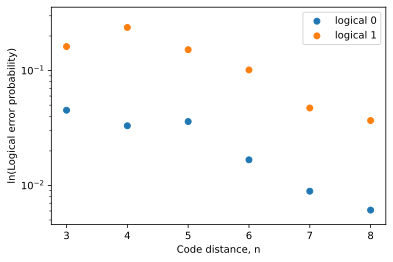

In [39]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = range(n_min,n_max+1)
P = { log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1'] }

ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter( x_axis, P['0'], label="logical 0")
ax.scatter( x_axis, P['1'], label="logical 1")
ax.set_yscale('log')
ax.set_ylim(ymax=1.5*max(P['0']+P['1']),ymin=0.75*min(P['0']+P['1']))
plt.legend()

plt.show()

私たちが得られる別の示唆は、結果を使用して、特定のエラープロセスが発生する可能性を判断することです。

これを行うには、シンドロームグラフの各エッジが、回路内の特定の地点で特定の量子ビットに発生している特定のエラー形式を表している事実を使います。
これは、隣接ノードの両方に対応するシンドローム値を変更する一意の単一エラーです。
その結果、シンドロームの確率を推定するために結果を使って、エラーイベントの確率を推定することができます。
具体的には、一次のオーダーでは以下が成り立ちます。

$$
\frac{p}{1-p} \approx \frac{C_{11}}{C_{00}}
$$

__ここで、$ p$ は特定のエッジに対応するエラー確率で、
$C_{11}$ は値`1`を取るノードを両端にもつシンドローム値に対応し、$C_{00}$は値`0`を取るノードを両端にもつシンドローム値に対応します。(Here $p$ is the probaility of the error corresponding to a particular edge, $C_{11}$ is the number of counts in the `results[n]['0']` correponding to the syndrome value of both adjacent nodes being `1`, and $C_{00}$ is the same for them both being `0`.)__

復号器オブジェクトには、これらの比率を決定し、各エッジに重み $-\ln(p/(1-p))$を割り当てるメソッド `weight_syndrome_graph`があります。
この方法を採用し、重みを調べることにより、これらの確率を簡単に取得できます。

In [40]:
if step_3:

    dec[n_max].weight_syndrome_graph(results=results[n_max])

    probs = []
    for edge in dec[n_max].S.edges:
        ratio = np.exp(-dec[n_max].S.get_edge_data(edge[0],edge[1])['distance'])
        probs.append( ratio/(1+ratio) )
        
    with open('results/probs_'+device_name+'.txt', 'w') as file:
        file.write(str(probs))
        
else:
    
    with open('results/probs_'+device_name+'.txt', 'r') as file:
        probs = eval(file.read())

完全なリストを表示するのではなく、平均値、標準偏差、最小値、最大値、四分位数を介して要約を取得できます。

In [41]:
import pandas as pd

pd.Series(probs).describe().to_dict()

{'count': 29.0,
 'mean': 0.18570187935383514,
 'std': 0.12966061187100625,
 'min': 0.014967523298503253,
 '25%': 0.05383187483426147,
 '50%': 0.1799797775530839,
 '75%': 0.2753350576063955,
 'max': 0.4345054945054945}

デバイスのベンチマークでは、完全に等しいエラー確率のセットは生成されません。
ただし、読み出しエラーと制御NOTゲートのエラー確率の比較は有用です。具体的には、`backend`オブジェクトを使用して、ベンチマークからこれらの値を取得できます。

In [42]:
if step_3:

    gate_probs = []
    for j,qubit in enumerate(line):
        
        gate_probs.append( backend.properties().readout_error(qubit) )
        
        cx1,cx2 = 0,0
        if j>0:
            gate_probs( backend.properties().gate_error('cx',[qubit,line[j-1]]) )
        if j<len(line)-1:
            gate_probs( backend.properties().gate_error('cx',[qubit,line[j+1]]) )
                
    with open('results/gate_probs_'+device_name+'.txt', 'w') as file:
        file.write(str(gate_probs))
        
else:
    
    with open('results/gate_probs_'+device_name+'.txt', 'r') as file:
        gate_probs = eval(file.read())
    
pd.Series(gate_probs).describe().to_dict()

{'count': 15.0,
 'mean': 0.08386929848831581,
 'std': 0.06860851140104485,
 'min': 0.02134613228239715,
 '25%': 0.050219500857068944,
 '50%': 0.05460651866864599,
 '75%': 0.09450000000000003,
 'max': 0.28}

In [43]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}